In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
regression_results = []
regression_columns = ["Model", "RMSE", "R2"]
classification_results = []
classification_columns = ["Model", "F1"]

In [3]:
df = pd.read_parquet('auto-cars.parquet')

In [4]:
df.head()

C:\ProgramData\anaconda3\Lib\site-packages\pandas\io\formats\format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
C:\ProgramData\anaconda3\Lib\site-packages\pandas\io\formats\format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,Brand,Model,Generation,Start of production,End of production,Modification (Engine),Powertrain Architecture,Body type,Fuel Type,Max. weight (kg),...,CO2 emission (g/km),CO2 emission CNG (g/km),CO2 emission LPG (g/km),CO2 emission Ethanol (g/km),Power (Ethanol),Torque (Ethanol),Maximum speed (Ethanol),Acceleration 0 - 100 km/h (Ethanol),Number of gears,Transmission type
0,Alpina,B9,B9 Coupe (E24),1982-01-01,1985-01-01,3.5 (245 Hp),Internal Combustion engine,Coupe,Petrol (Gasoline),0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
1,Alpina,B11,B11 (E32),1987-01-01,1987-01-01,3.5 (250 Hp),Internal Combustion engine,Sedan,Petrol (Gasoline),0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
2,Alpina,B9,B9 (E28),1981-01-01,1985-01-01,3.0 (245 Hp),Internal Combustion engine,Sedan,Petrol (Gasoline),0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
3,Alpina,B11,B11 (E32),1987-01-01,1993-01-01,3.5 (254 Hp),Internal Combustion engine,Sedan,Petrol (Gasoline),0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
4,Alpina,C2,C2 Cabrio (E30),1986-02-01,1987-07-01,2.7 (209 Hp),Internal Combustion engine,Cabriolet,Petrol (Gasoline),0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN


In [5]:
keywords = ["cng", "lpg", "ethanol"]
# drop any cng, lpg, ethanol columns, they add extra complexity along with their low sample size
df = df.loc[:, ~df.columns.str.lower().str.contains('|'.join(keywords))]

In [6]:
list(df.columns)

['Brand',
 'Model',
 'Generation',
 'Start of production',
 'End of production',
 'Modification (Engine)',
 'Powertrain Architecture',
 'Body type',
 'Fuel Type',
 'Max. weight (kg)',
 'Length (mm)',
 'Width (mm)',
 'Height (mm)',
 'Front suspension',
 'Battery weight (kg)',
 'Engine aspiration',
 'Recuperation output (kW)',
 'Gross battery capacity (kWh)',
 'Power (kW)',
 'Emission standard',
 'Compression ratio',
 'Permitted trailer load with brakes (12%) (kg)',
 'Wheelbase (mm)',
 'Acceleration 0 - 100 km/h',
 'Ramp-over (brakeover) angle',
 'AdBlue tank (l)',
 'Number of cylinders',
 'Drivetrain Architecture',
 'Permitted trailer load with brakes (8%) (kg)',
 'Torque (Nm)',
 'System power (kW)',
 'Front track (mm)',
 'Fuel injection system',
 'Engine systems',
 'Battery voltage (V)',
 'Rear suspension',
 'Max. roof load (kg)',
 'Piston Stroke (mm)',
 'Width including mirrors (mm)',
 'Max load (kg)',
 'Wading depth (mm)',
 '100 km/h - 0 (m)',
 'Engine configuration',
 'Assisting sys

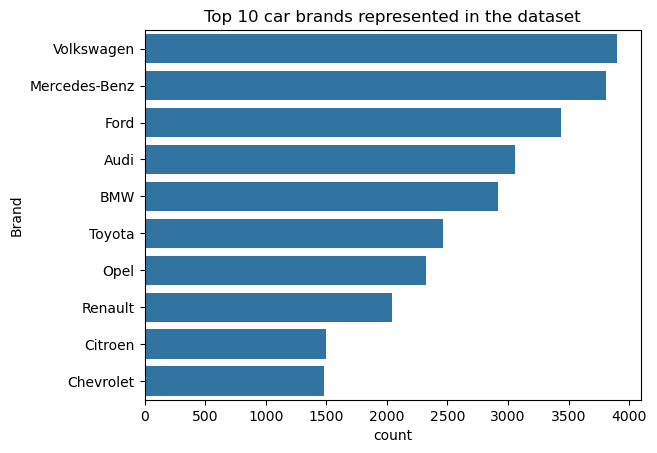

In [7]:

sns.countplot(data=df, y='Brand', order=df['Brand'].value_counts().iloc[:10].index)
plt.title("Top 10 car brands represented in the dataset")
plt.savefig("top10carbrands.svg", format="svg", bbox_inches='tight')
plt.show()

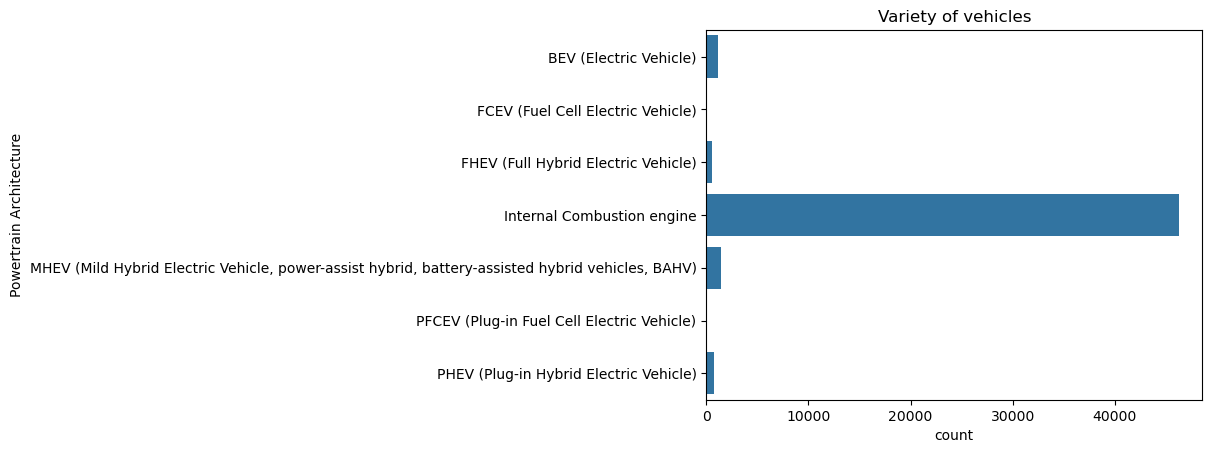

In [8]:
sns.countplot(data=df, y='Powertrain Architecture')
plt.title("Variety of vehicles")
plt.savefig("varietyofvehicles.svg", format="svg", bbox_inches='tight')
plt.show()

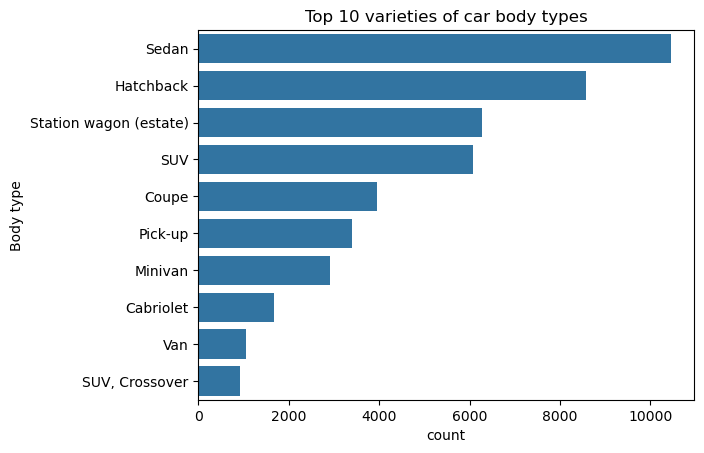

In [9]:
sns.countplot(data=df, y='Body type', order=df['Body type'].value_counts().iloc[:10].index)
plt.title("Top 10 varieties of car body types")
plt.savefig("top10carbodytypes.svg", format="svg", bbox_inches='tight')
plt.show()

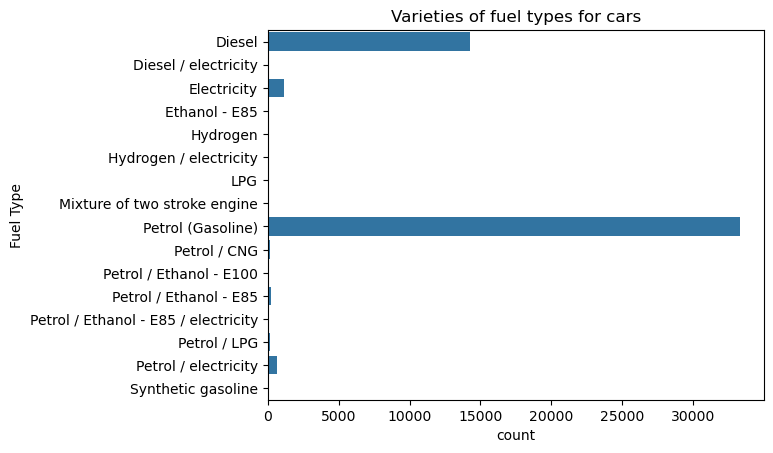

In [10]:
sns.countplot(data=df, y='Fuel Type')#, order=df['Fuel Type'].value_counts().iloc[:20].index)
plt.title("Varieties of fuel types for cars")
plt.savefig("carfueltypes.svg", format="svg", bbox_inches='tight')
plt.show()

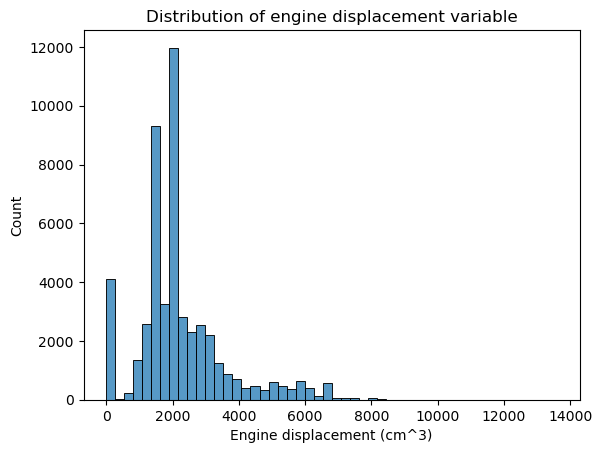

In [11]:
sns.histplot(data=df, x='Engine displacement (cm^3)', bins=50)
plt.title("Distribution of engine displacement variable")
plt.savefig("distributionofenginedisplacement.svg", format="svg", bbox_inches='tight')
plt.show()

In [12]:
def permutation_test_iteration(df):
    data = df.apply(lambda col: np.random.permutation(col.values))
    
    corr_matrix = np.abs(data.corr(min_periods=100))
    corr_matrix.values[np.triu_indices_from(corr_matrix, 0)] = np.nan
    corr_matrix_s = corr_matrix.stack()
    return corr_matrix_s.max()

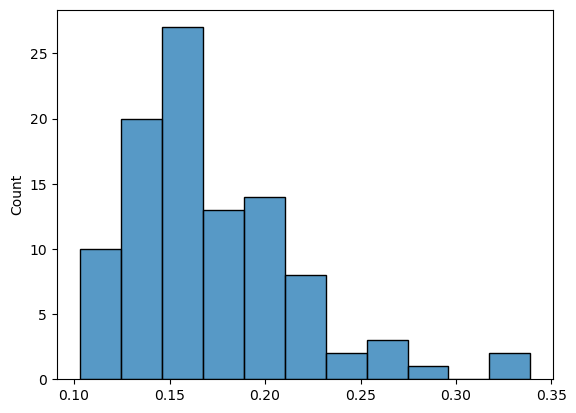

In [13]:
from joblib import Parallel, delayed

n_shuffles = 100

c_df = df.copy()
for col in df.select_dtypes(include=["datetime64[ns]"]).columns:
    c_df[col] = c_df[col].dt.year

cols = ['Length (mm)', 'Width (mm)', 'Height (mm)']
c_df['Volume (mm^3)'] = c_df[cols].prod(axis=1)
c_df = c_df.drop(cols, axis=1)
c_df = c_df.drop('End of production', axis=1)

#for col in c_df.select_dtypes(include=['object', 'category']).columns:
#    c_df[col] = c_df[col].astype('category').cat.codes

num_df = c_df.select_dtypes(include=['number'])

max_corrs = Parallel(n_jobs=-1)(delayed(permutation_test_iteration)(num_df) for _ in range(n_shuffles))

sns.histplot(max_corrs)
plt.show()

In [14]:
max_corrs[:10]

[0.14499988661366944,
 0.14498565425417015,
 0.1518920329916051,
 0.19136188269729684,
 0.21402961512592597,
 0.16936632921815692,
 0.10991135527350408,
 0.17188187052968687,
 0.14075644842470275,
 0.15466750424685966]

In [15]:
corr_matrix = np.abs(num_df.corr())
corr_matrix.values[np.triu_indices_from(corr_matrix, 0)] = np.nan
corr_matrix_s = corr_matrix.stack()
(corr_matrix_s > max(max_corrs)).sum()

np.int64(278)

In [16]:
threshold = max(max_corrs)
exceeds = np.where(corr_matrix > threshold)

# Convert indices to column name pairs
high_corr_pairs = [(corr_matrix.index[i], corr_matrix.columns[j], corr_matrix.values[i, j])
                   for i, j in zip(*exceeds)]

# Optional: sort by correlation descending
high_corr_pairs = sorted(high_corr_pairs, key=lambda x: x[2], reverse=True)

ignore_cols = [ "Start of production"]

# Print results
for c1, c2, corr in high_corr_pairs:
    if any(sub.lower() in c1.lower() or sub.lower() in c2.lower() for sub in ignore_cols):
        print(f"{c1} <-> {c2}: correlation = {corr:.3f}")

Number of valves per cylinder <-> Start of production: correlation = 0.510
Climb angle <-> Start of production: correlation = 0.494
Number of gears <-> Start of production: correlation = 0.488
Drag coefficient (C) <-> Start of production: correlation = 0.467
Width including mirrors (mm) <-> Start of production: correlation = 0.459
Wheelbase (mm) <-> Start of production: correlation = 0.393
Acceleration 0 - 100 km/h <-> Start of production: correlation = 0.383
Doors <-> Start of production: correlation = 0.380
Torque (Nm) <-> Start of production: correlation = 0.376
Kerb Weight (kg) <-> Start of production: correlation = 0.374
CO2 emission (g/km) <-> Start of production: correlation = 0.362
Net (usable) battery capacity (kWh) <-> Start of production: correlation = 0.357
Piston Stroke (mm) <-> Start of production: correlation = 0.356
Permitted trailer load with brakes (12%) (kg) <-> Start of production: correlation = 0.345
Permitted trailer load without brakes (kg) <-> Start of productio

In [17]:
data = df.copy()

data['Start of production'] = data['Start of production'].dt.year
data['End of production'] = data['End of production'].dt.year

#for col in data.select_dtypes(include=['object', 'category']).columns:
#    data[col] = data[col].astype('category').cat.codes

#data = data.select_dtypes(include=['number'])

data = pd.get_dummies(data)

data = data[data['Fuel consumption (L/100km)'].notna() & (data['Fuel consumption (L/100km)'] != 0)]

X = data.drop('Fuel consumption (L/100km)', axis=1).fillna(0)
y = data['Fuel consumption (L/100km)']

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [20]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Lasso

In [21]:
lr = Lasso().fit(X_train, y_train)

In [22]:
y_pred = lr.predict(X_test)

In [23]:
from sklearn.metrics import mean_squared_error, r2_score

In [24]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
regression_results.append(["Linear Lasso (Fuel Consumption)", rmse, r2])
print("RMSE:", rmse)
print("R2:", r2)

RMSE: 1.1776202395015136
R2: 0.8052807349686848


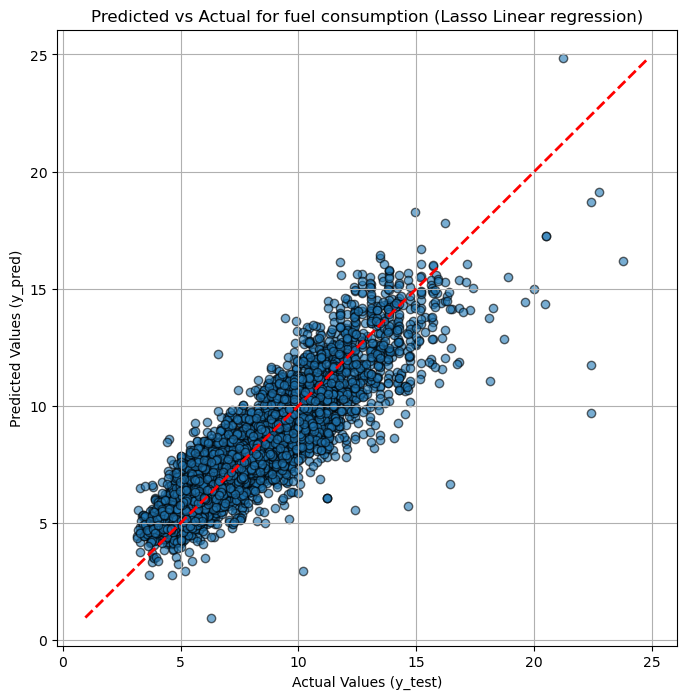

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))

plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
plt.xlabel("Actual Values (y_test)")
plt.ylabel("Predicted Values (y_pred)")
plt.title("Predicted vs Actual for fuel consumption (Lasso Linear regression)")

# Add a diagonal line (perfect predictions)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'r--', linewidth=2)

plt.grid(True)
plt.savefig("pred_vs_act_fuel_consumption_lasso.svg", format="svg", bbox_inches='tight')
plt.show()

In [26]:
lr.coef_

array([-0.07391672, -0.00022788,  0.00032367, ...,  0.        ,
        0.        , -0.        ])

In [27]:
coef_df = pd.DataFrame({
    "feature": X_train.columns,
    "coefficient": abs(lr.coef_)
})
coef_df = coef_df.sort_values(by="coefficient", ascending=False)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(coef_df.iloc[:10])

                       feature  coefficient
0          Start of production     0.073917
9                   Power (kW)     0.025254
28      Fuel tank capacity (l)     0.013591
17                 Torque (Nm)     0.010372
18           System power (kW)     0.007821
48        Maximum speed (km/h)     0.002599
5                  Height (mm)     0.001695
24               Max load (kg)     0.001679
52  Engine displacement (cm^3)     0.001024
20         Battery voltage (V)     0.000972


In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer

In [29]:
data = df.copy()

data['Start of production'] = data['Start of production'].dt.year
data['End of production'] = data['End of production'].dt.year

for col in data.select_dtypes(include=['object', 'category']).columns:
    data[col] = data[col].astype('category').cat.codes

#data = data.select_dtypes(include=['number'])

#data = pd.get_dummies(data)

data = data[data['Fuel consumption (L/100km)'].notna() & (data['Fuel consumption (L/100km)'] != 0)]

X = data.drop('Fuel consumption (L/100km)', axis=1).fillna(0)
y = data['Fuel consumption (L/100km)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [30]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'max_features': ['sqrt', 0.8],
    'min_samples_split': [2, 5]
}

rmse_scorer = make_scorer(
    lambda y_true, y_pred: -np.sqrt(mean_squared_error(y_true, y_pred))
)

cv = KFold(n_splits=5, shuffle=True, random_state=42)

rf = RandomForestRegressor(n_jobs=-1)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=rmse_scorer,   # maximize negative RMSE
    cv=cv,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
print("Best CV score (RMSE):", -grid_search.best_score_)

#model = RandomForestRegressor(n_estimators=100, n_jobs=-1)
#model.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best hyperparameters: {'max_depth': None, 'max_features': 0.8, 'min_samples_split': 2, 'n_estimators': 200}
Best CV score (RMSE): 0.5190785885540782


In [31]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
regression_results.append(["RandomForestRegressor (Fuel Consumption)", rmse, r2])
print("RMSE:", rmse)
print("R2:", r2)

RMSE: 0.511147929323419
R2: 0.9633467199056911


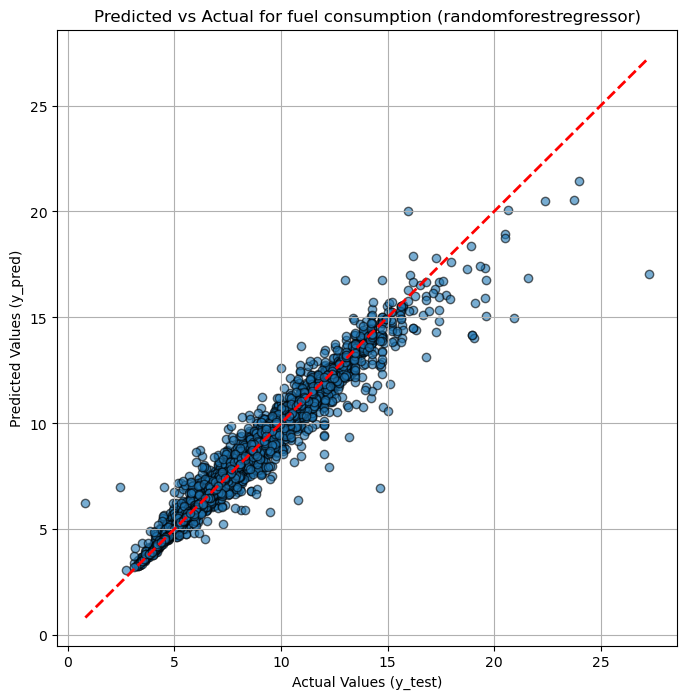

In [32]:
plt.figure(figsize=(8, 8))

plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
plt.xlabel("Actual Values (y_test)")
plt.ylabel("Predicted Values (y_pred)")
plt.title("Predicted vs Actual for fuel consumption (randomforestregressor)")

# Add a diagonal line (perfect predictions)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'r--', linewidth=2)

plt.grid(True)
plt.savefig("pred_act_fuel_consumption_randomforestregressor.svg", format="svg", bbox_inches='tight')
plt.show()

In [33]:

# Get feature importances
importances = best_model.feature_importances_

# Combine with column names
feat_imp = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
})

# Sort descending
feat_imp = feat_imp.sort_values(by='importance', ascending=False)
print(feat_imp.iloc[:20])

                       feature  importance
81  Engine displacement (cm^3)    0.484733
26         Number of cylinders    0.089756
8                    Fuel Type    0.084244
86         CO2 emission (g/km)    0.074528
19           Emission standard    0.045065
5        Modification (Engine)    0.023339
46      Fuel tank capacity (l)    0.018611
12                 Height (mm)    0.017983
3          Start of production    0.016616
59          Cylinder Bore (mm)    0.013550
42        Engine configuration    0.010741
18                  Power (kW)    0.010499
32       Fuel injection system    0.008657
78            Kerb Weight (kg)    0.007670
76        Maximum speed (km/h)    0.006630
9             Max. weight (kg)    0.005868
4            End of production    0.004316
23   Acceleration 0 - 100 km/h    0.004230
29                 Torque (Nm)    0.003993
20           Compression ratio    0.003839


In [34]:
import xgboost as xgb

In [35]:
data = df.copy()

data['Start of production'] = data['Start of production'].dt.year
data['End of production'] = data['End of production'].dt.year

for col in data.select_dtypes(include=['object', 'category']).columns:
    data[col] = data[col].astype('category').cat.codes

#data = data.select_dtypes(include=['number'])

#data = pd.get_dummies(data)

data = data[data['Fuel consumption (L/100km)'].notna() & (data['Fuel consumption (L/100km)'] != 0)]

X = data.drop('Fuel consumption (L/100km)', axis=1).fillna(0)
y = data['Fuel consumption (L/100km)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [36]:
param_grid = {
    'n_estimators': [500],
    'max_depth': [20],
    'subsample': [0.9],           # fraction of rows for each tree
    'colsample_bytree':[0.9],    # fraction of features for each tree
    'learning_rate': [0.05]
}

rmse_scorer = make_scorer(
    lambda y_true, y_pred: -np.sqrt(mean_squared_error(y_true, y_pred))
)

cv = KFold(n_splits=5, shuffle=True)

rf = xgb.XGBRegressor(n_jobs=-1)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=rmse_scorer,   # maximize negative RMSE
    cv=cv,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
print("Best CV score (RMSE):", -grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)


#model = xgb.XGBRegressor(
#    n_estimators=1000,        # number of trees
#    max_depth=None,             # max tree depth
#    learning_rate=0.1,       # step size shrinkage
#    subsample=0.9,           # fraction of rows for each tree
#    colsample_bytree=0.9,    # fraction of features for each tree
#    n_jobs=-1                # use all CPU cores
#)

#model.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters: {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 20, 'n_estimators': 500, 'subsample': 0.9}
Best CV score (RMSE): 0.49498118619058146


In [37]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
regression_results.append(["XGBRegressor (Fuel Consumption)", rmse, r2])
print("RMSE:", rmse)
print("R2:", r2)

RMSE: 0.489984349784241
R2: 0.965552806854248


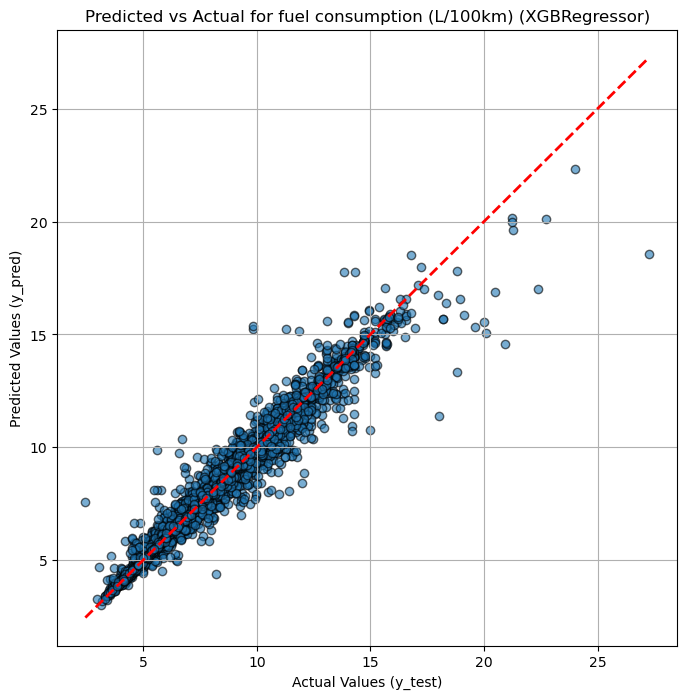

In [38]:
plt.figure(figsize=(8, 8))

plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
plt.xlabel("Actual Values (y_test)")
plt.ylabel("Predicted Values (y_pred)")
plt.title("Predicted vs Actual for fuel consumption (L/100km) (XGBRegressor)")

# Add a diagonal line (perfect predictions)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'r--', linewidth=2)
plt.grid(True)
plt.savefig("pred_act_fuel_consumption_xgbregressor.svg", format="svg", bbox_inches='tight')
plt.show()

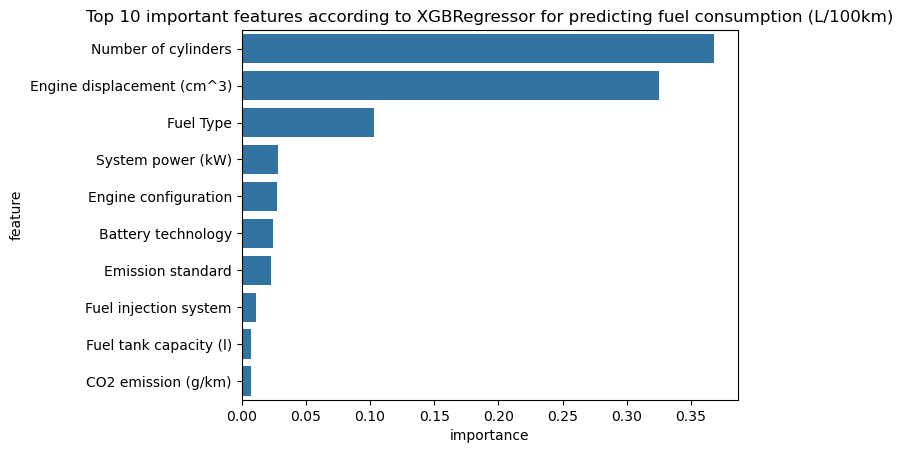

In [39]:
# Get feature importances
importances = best_model.feature_importances_

# Combine with column names
feat_imp = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
})

# Sort descending
feat_imp = feat_imp.sort_values(by='importance', ascending=False)
sns.barplot(data=feat_imp.iloc[:10], y='feature', x='importance')
plt.title("Top 10 important features according to XGBRegressor for predicting fuel consumption (L/100km)")
plt.savefig("top10_important_features_fuel_consumption_xgbregressor.svg", format="svg", bbox_inches='tight')
plt.show()

In [40]:
best_model.save_model("xgb_fuel_model.json")

In [41]:
data = df.copy()

cols = ['Length (mm)', 'Width (mm)', 'Height (mm)']
data['Volume (mm^3)'] = data[cols].prod(axis=1)
data = data.drop(cols, axis=1)

target_feature = 'Volume (mm^3)'

data['Start of production'] = data['Start of production'].dt.year
data['End of production'] = data['End of production'].dt.year

for col in data.select_dtypes(include=['object', 'category']).columns:
    data[col] = data[col].astype('category').cat.codes

data = data[data[target_feature].notna() & (data[target_feature] != 0)]

X = data.drop(target_feature, axis=1).fillna(0)
y = data[target_feature]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [42]:
param_grid = {
    'n_estimators': [500],
    'max_depth': [10],
    'subsample': [0.9],           # fraction of rows for each tree
    'colsample_bytree':[0.9],    # fraction of features for each tree
    'learning_rate': [0.05]
}

rmse_scorer = make_scorer(
    lambda y_true, y_pred: -np.sqrt(mean_squared_error(y_true, y_pred))
)

cv = KFold(n_splits=5, shuffle=True)

rf = xgb.XGBRegressor(n_jobs=-1)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=rmse_scorer,   # maximize negative RMSE
    cv=cv,
    n_jobs=4,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
print("Best CV score (RMSE):", -grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters: {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 500, 'subsample': 0.9}
Best CV score (RMSE): 274384437.1477996


In [43]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
regression_results.append(["XGBRegressor (Volume)", rmse, r2])
print("RMSE:", rmse)
print("R2:", r2)

RMSE: 238363630.64790702
R2: 0.9952348470687866


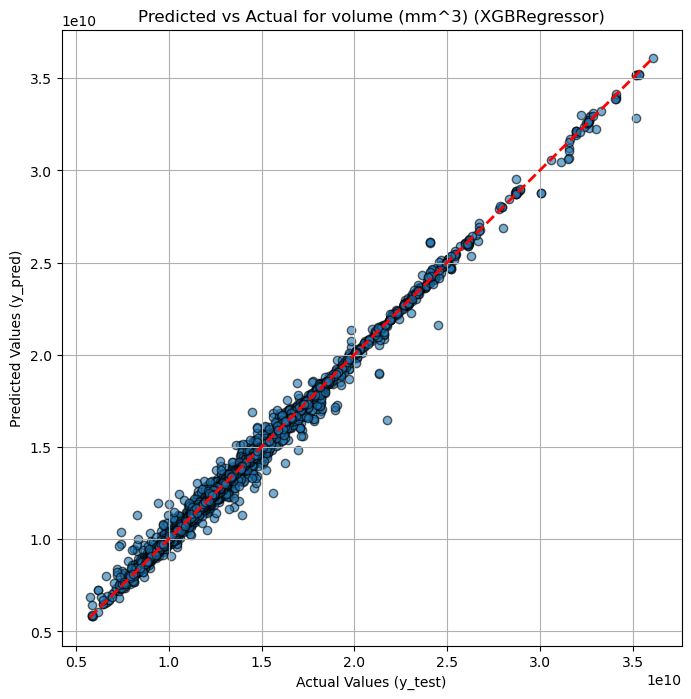

In [44]:
plt.figure(figsize=(8, 8))

plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
plt.xlabel("Actual Values (y_test)")
plt.ylabel("Predicted Values (y_pred)")
plt.title("Predicted vs Actual for volume (mm^3) (XGBRegressor)")

# Add a diagonal line (perfect predictions)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'r--', linewidth=2)
plt.grid(True)
plt.savefig("pred_act_volume_xgbregressor.svg", format="svg", bbox_inches='tight')
plt.show()

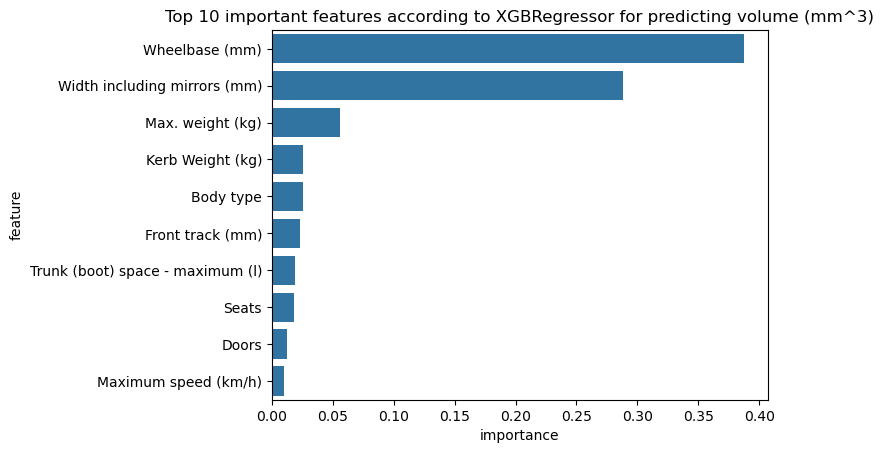

In [45]:
# Get feature importances
importances = best_model.feature_importances_

# Combine with column names
feat_imp = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
})

# Sort descending
feat_imp = feat_imp.sort_values(by='importance', ascending=False)
sns.barplot(data=feat_imp.iloc[:10], y='feature', x='importance')
plt.title("Top 10 important features according to XGBRegressor for predicting volume (mm^3)")
plt.savefig("top10_important_features_volume_xgbregressor.svg", format="svg", bbox_inches='tight')
plt.show()

In [46]:
best_model.save_model("xgb_volume_model.json")

In [47]:
data = df.copy()

target_feature = 'CO2 emission (g/km)'

data['Start of production'] = data['Start of production'].dt.year
data['End of production'] = data['End of production'].dt.year

for col in data.select_dtypes(include=['object', 'category']).columns:
    data[col] = data[col].astype('category').cat.codes

data = data[data[target_feature].notna() & (data[target_feature] != 0)]

X = data.drop(target_feature, axis=1).fillna(0)
y = data[target_feature]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [48]:
param_grid = {
    'n_estimators': [500],
    'max_depth': [10],
    'subsample': [0.9],           # fraction of rows for each tree
    'colsample_bytree':[0.9],    # fraction of features for each tree
    'learning_rate': [0.05]
}

rmse_scorer = make_scorer(
    lambda y_true, y_pred: -np.sqrt(mean_squared_error(y_true, y_pred))
)

cv = KFold(n_splits=5, shuffle=True)

rf = xgb.XGBRegressor(n_jobs=-1)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=rmse_scorer,   # maximize negative RMSE
    cv=cv,
    n_jobs=4,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
print("Best CV score (RMSE):", -grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters: {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 500, 'subsample': 0.9}
Best CV score (RMSE): 7.4102565033452095


In [49]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
regression_results.append(["XGBRegressor (CO2)", rmse, r2])
print("RMSE:", rmse)
print("R2:", r2)

RMSE: 6.820801882320809
R2: 0.9851831197738647


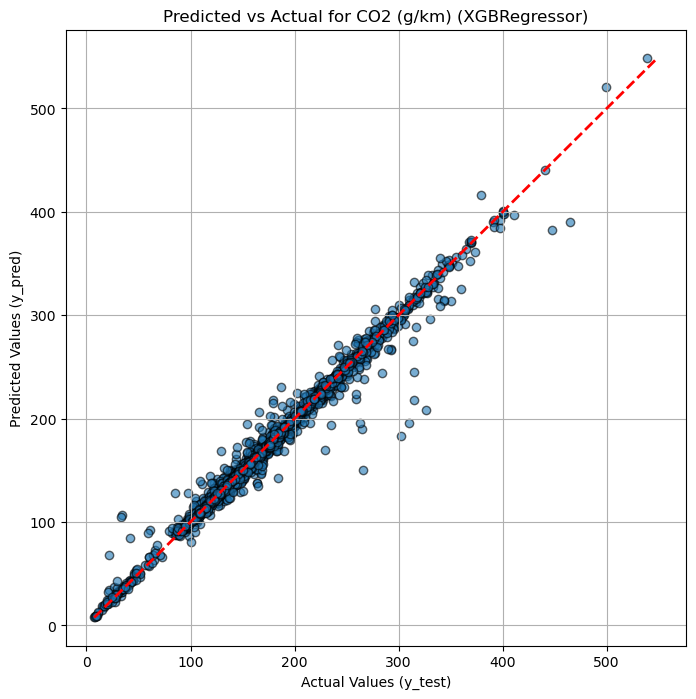

In [50]:
plt.figure(figsize=(8, 8))

plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
plt.xlabel("Actual Values (y_test)")
plt.ylabel("Predicted Values (y_pred)")
plt.title("Predicted vs Actual for CO2 (g/km) (XGBRegressor)")

# Add a diagonal line (perfect predictions)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'r--', linewidth=2)
plt.grid(True)
plt.savefig("pred_act_co2_xgbregressor.svg", format="svg", bbox_inches='tight')
plt.show()

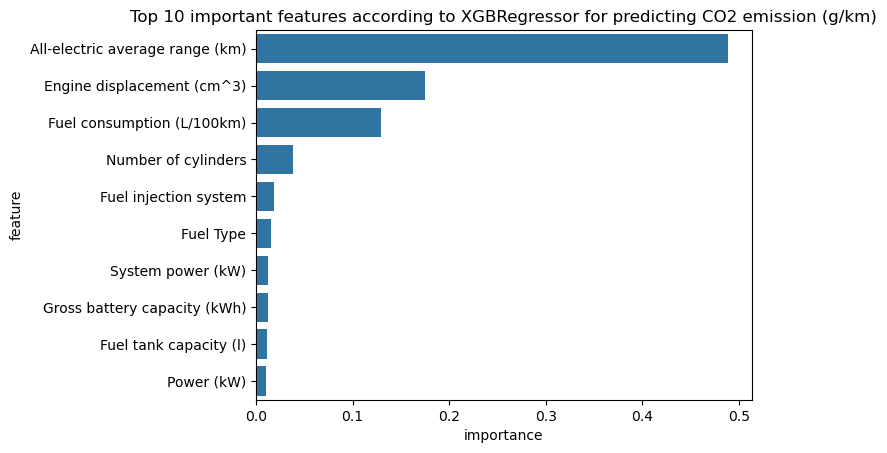

In [51]:
# Get feature importances
importances = best_model.feature_importances_

# Combine with column names
feat_imp = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
})

# Sort descending
feat_imp = feat_imp.sort_values(by='importance', ascending=False)
sns.barplot(data=feat_imp.iloc[:10], y='feature', x='importance')
plt.title("Top 10 important features according to XGBRegressor for predicting CO2 emission (g/km)")
plt.savefig("top10_important_features_co2_xgbregressor.svg", format="svg", bbox_inches='tight')
plt.show()

In [52]:
best_model.save_model("xgb_co2_model.json")

In [53]:
data = df.copy()

target_feature = 'Acceleration 0 - 100 km/h'

data['Start of production'] = data['Start of production'].dt.year
data['End of production'] = data['End of production'].dt.year

for col in data.select_dtypes(include=['object', 'category']).columns:
    data[col] = data[col].astype('category').cat.codes

data = data[data[target_feature].notna() & (data[target_feature] != 0)]

X = data.drop(target_feature, axis=1).fillna(0)
y = data[target_feature]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [54]:
param_grid = {
    'n_estimators': [500],
    'max_depth': [10],
    'subsample': [0.9],           # fraction of rows for each tree
    'colsample_bytree':[0.9],    # fraction of features for each tree
    'learning_rate': [0.05]
}

rmse_scorer = make_scorer(
    lambda y_true, y_pred: -np.sqrt(mean_squared_error(y_true, y_pred))
)

cv = KFold(n_splits=5, shuffle=True)

rf = xgb.XGBRegressor(n_jobs=-1)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=rmse_scorer,   # maximize negative RMSE
    cv=cv,
    n_jobs=5,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
print("Best CV score (RMSE):", -grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters: {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 500, 'subsample': 0.9}
Best CV score (RMSE): 0.5586955853925085


In [55]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
regression_results.append(["XGBRegressor (Acceleration)", rmse, r2])
print("RMSE:", rmse)
print("R2:", r2)

RMSE: 0.49054065574644007
R2: 0.9785776734352112


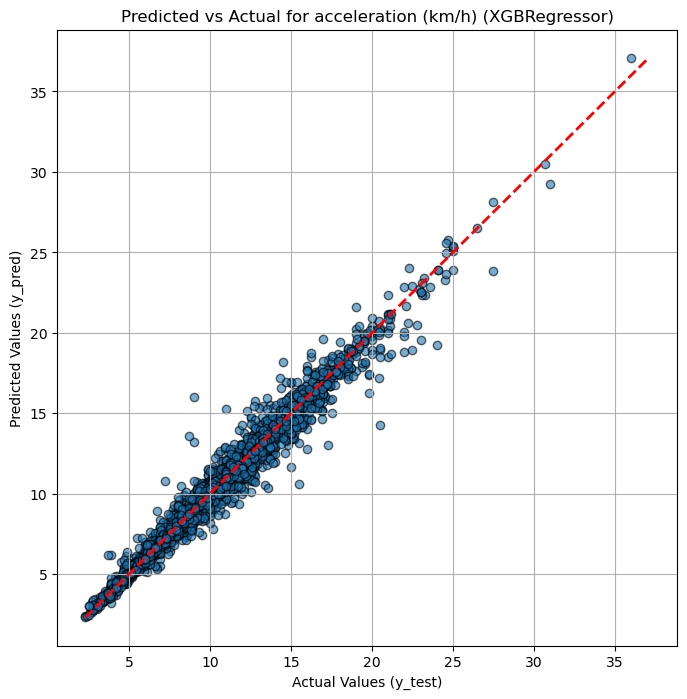

In [56]:
plt.figure(figsize=(8, 8))

plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
plt.xlabel("Actual Values (y_test)")
plt.ylabel("Predicted Values (y_pred)")
plt.title("Predicted vs Actual for acceleration (km/h) (XGBRegressor)")

# Add a diagonal line (perfect predictions)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'r--', linewidth=2)
plt.grid(True)
plt.savefig("pred_act_acceleration_xgbregressor.svg", format="svg", bbox_inches='tight')
plt.show()

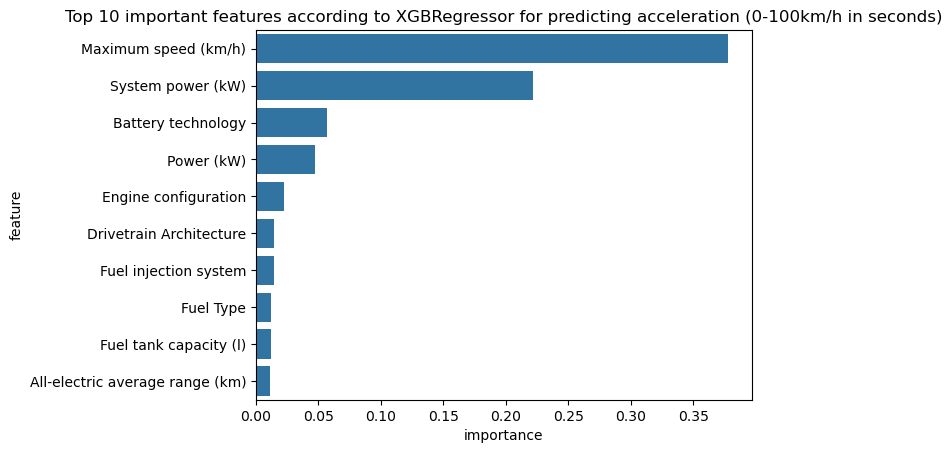

In [57]:
# Get feature importances
importances = best_model.feature_importances_

# Combine with column names
feat_imp = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
})

# Sort descending
feat_imp = feat_imp.sort_values(by='importance', ascending=False)
sns.barplot(data=feat_imp.iloc[:10], y='feature', x='importance')
plt.title("Top 10 important features according to XGBRegressor for predicting acceleration (0-100km/h in seconds)")
plt.savefig("top10_important_features_acceleration_xgbregressor.svg", format="svg", bbox_inches='tight')
plt.show()

In [58]:
best_model.save_model("xgb_acceleration_model.json")

In [59]:
data = df.copy()

target_feature = 'Maximum speed (km/h)'

data['Start of production'] = data['Start of production'].dt.year
data['End of production'] = data['End of production'].dt.year

for col in data.select_dtypes(include=['object', 'category']).columns:
    data[col] = data[col].astype('category').cat.codes

data = data[data[target_feature].notna() & (data[target_feature] != 0)]

X = data.drop(target_feature, axis=1).fillna(0)
y = data[target_feature]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [60]:
param_grid = {
    'n_estimators': [500],
    'max_depth': [10],
    'subsample': [0.9],           # fraction of rows for each tree
    'colsample_bytree':[0.9],    # fraction of features for each tree
    'learning_rate': [0.05]
}

rmse_scorer = make_scorer(
    lambda y_true, y_pred: -np.sqrt(mean_squared_error(y_true, y_pred))
)

cv = KFold(n_splits=5, shuffle=True)

rf = xgb.XGBRegressor(n_jobs=-1)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=rmse_scorer,   # maximize negative RMSE
    cv=cv,
    n_jobs=5,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
print("Best CV score (RMSE):", -grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters: {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 500, 'subsample': 0.9}
Best CV score (RMSE): 5.473293645427741


In [61]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
regression_results.append(["XGBRegressor (Max speed)", rmse, r2])
print("RMSE:", rmse)
print("R2:", r2)

RMSE: 6.068198445926962
R2: 0.9717274904251099


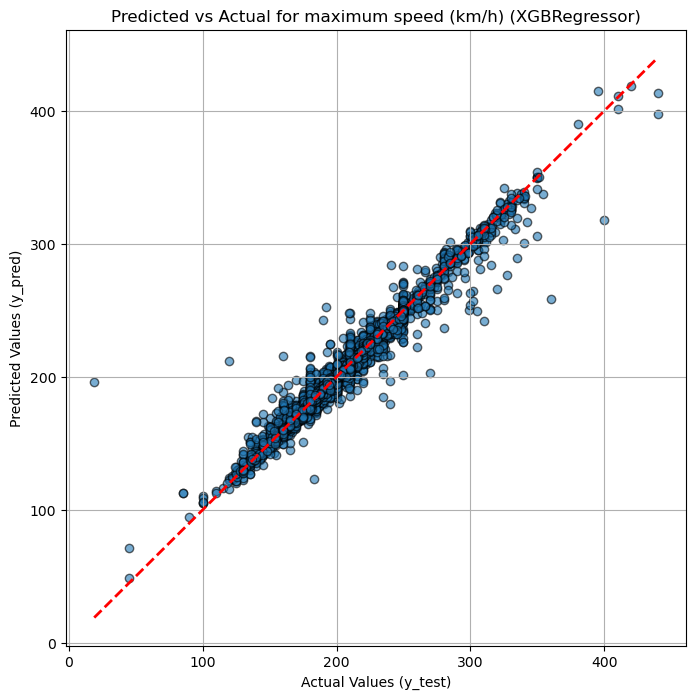

In [62]:
plt.figure(figsize=(8, 8))

plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
plt.xlabel("Actual Values (y_test)")
plt.ylabel("Predicted Values (y_pred)")
plt.title("Predicted vs Actual for maximum speed (km/h) (XGBRegressor)")

# Add a diagonal line (perfect predictions)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'r--', linewidth=2)
plt.grid(True)
plt.savefig("pred_act_max_speed_xgbregressor.svg", format="svg", bbox_inches='tight')
plt.show()

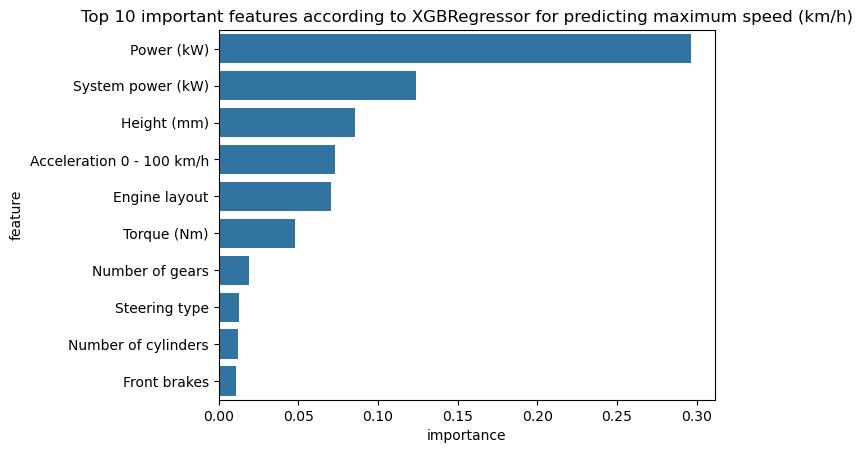

In [63]:
# Get feature importances
importances = best_model.feature_importances_

# Combine with column names
feat_imp = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
})

# Sort descending
feat_imp = feat_imp.sort_values(by='importance', ascending=False)
sns.barplot(data=feat_imp.iloc[:10], y='feature', x='importance')
plt.title("Top 10 important features according to XGBRegressor for predicting maximum speed (km/h)")
plt.savefig("top10_important_features_max_speed_xgbregressor.svg", format="svg", bbox_inches='tight')
plt.show()

In [64]:
best_model.save_model("xgb_maxspeed_model.json")

In [65]:
data = df.copy()

target_feature = 'Power (kW)'

data['Start of production'] = data['Start of production'].dt.year
data['End of production'] = data['End of production'].dt.year

for col in data.select_dtypes(include=['object', 'category']).columns:
    data[col] = data[col].astype('category').cat.codes

data = data[data[target_feature].notna() & (data[target_feature] != 0)]

X = data.drop(target_feature, axis=1).fillna(0)
y = data[target_feature]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [66]:
param_grid = {
    'n_estimators': [500],
    'max_depth': [10],
    'subsample': [0.9],           # fraction of rows for each tree
    'colsample_bytree':[0.9],    # fraction of features for each tree
    'learning_rate': [0.05]
}

rmse_scorer = make_scorer(
    lambda y_true, y_pred: -np.sqrt(mean_squared_error(y_true, y_pred))
)

cv = KFold(n_splits=5, shuffle=True)

rf = xgb.XGBRegressor(n_jobs=-1)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=rmse_scorer,   # maximize negative RMSE
    cv=cv,
    n_jobs=5,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
print("Best CV score (RMSE):", -grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters: {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 500, 'subsample': 0.9}
Best CV score (RMSE): 8.660749162817664


In [67]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
regression_results.append(["XGBRegressor (Power)", rmse, r2])
print("RMSE:", rmse)
print("R2:", r2)

RMSE: 7.483424880976541
R2: 0.9918923377990723


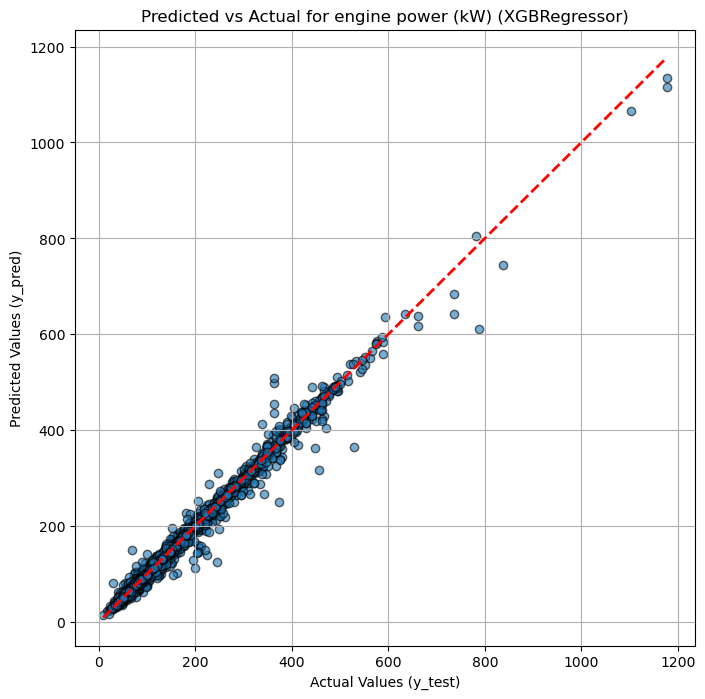

In [68]:
plt.figure(figsize=(8, 8))

plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
plt.xlabel("Actual Values (y_test)")
plt.ylabel("Predicted Values (y_pred)")
plt.title("Predicted vs Actual for engine power (kW) (XGBRegressor)")

# Add a diagonal line (perfect predictions)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'r--', linewidth=2)
plt.grid(True)
plt.savefig("pred_act_power_xgbregressor.svg", format="svg", bbox_inches='tight')
plt.show()

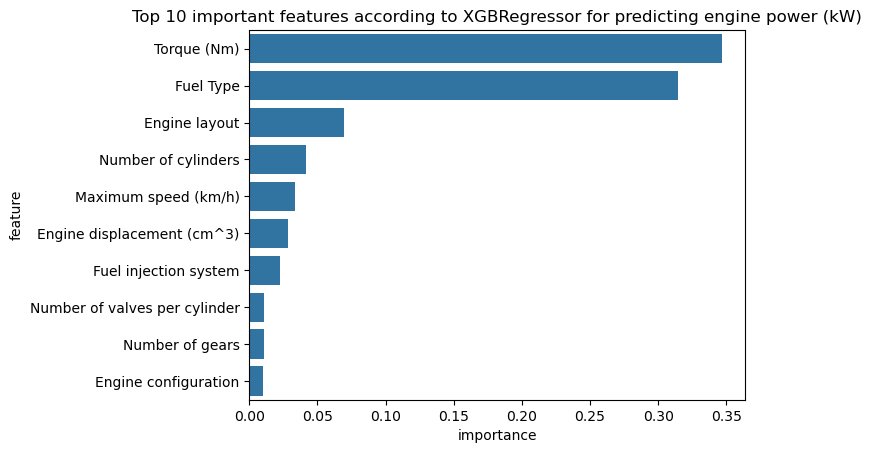

In [69]:
# Get feature importances
importances = best_model.feature_importances_

# Combine with column names
feat_imp = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
})

# Sort descending
feat_imp = feat_imp.sort_values(by='importance', ascending=False)
sns.barplot(data=feat_imp.iloc[:10], y='feature', x='importance')
plt.title("Top 10 important features according to XGBRegressor for predicting engine power (kW)")
plt.savefig("top10_important_features_power_xgbregressor.svg", format="svg", bbox_inches='tight')
plt.show()

In [70]:
best_model.save_model("xgb_engine_power_model.json")

In [71]:
data = df.copy()

target_feature = 'Torque (Nm)'

data['Start of production'] = data['Start of production'].dt.year
data['End of production'] = data['End of production'].dt.year

for col in data.select_dtypes(include=['object', 'category']).columns:
    data[col] = data[col].astype('category').cat.codes

data = data[data[target_feature].notna() & (data[target_feature] != 0)]

X = data.drop(target_feature, axis=1).fillna(0)
y = data[target_feature]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [72]:
param_grid = {
    'n_estimators': [500],
    'max_depth': [10],
    'subsample': [0.9],           # fraction of rows for each tree
    'colsample_bytree':[0.9],    # fraction of features for each tree
    'learning_rate': [0.05]
}

rmse_scorer = make_scorer(
    lambda y_true, y_pred: -np.sqrt(mean_squared_error(y_true, y_pred))
)

cv = KFold(n_splits=5, shuffle=True)

rf = xgb.XGBRegressor(n_jobs=-1)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=rmse_scorer,   # maximize negative RMSE
    cv=cv,
    n_jobs=5,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
print("Best CV score (RMSE):", -grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters: {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 500, 'subsample': 0.9}
Best CV score (RMSE): 14.544046041957643


In [73]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
regression_results.append(["XGBRegressor (Torque)", rmse, r2])
print("RMSE:", rmse)
print("R2:", r2)

RMSE: 17.437285609961183
R2: 0.9908679723739624


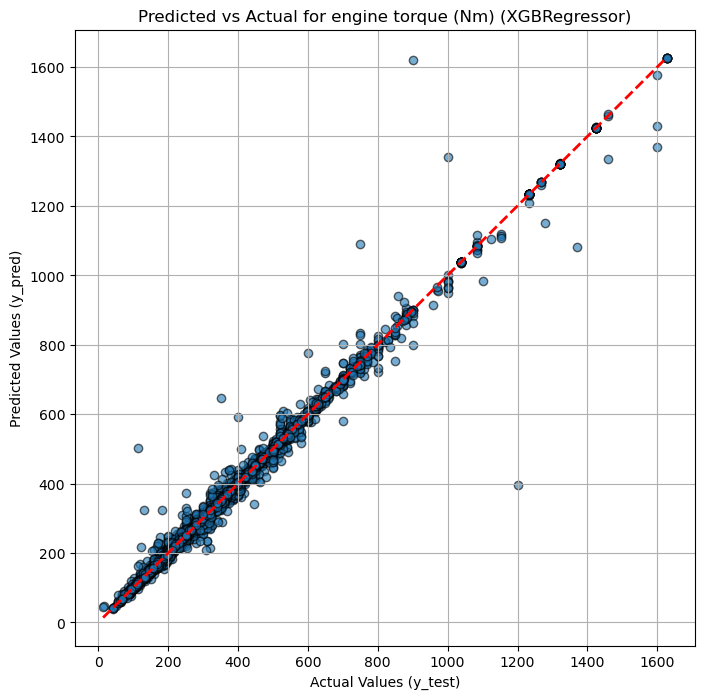

In [74]:
plt.figure(figsize=(8, 8))

plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
plt.xlabel("Actual Values (y_test)")
plt.ylabel("Predicted Values (y_pred)")
plt.title("Predicted vs Actual for engine torque (Nm) (XGBRegressor)")

# Add a diagonal line (perfect predictions)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'r--', linewidth=2)
plt.grid(True)
plt.savefig("pred_act_torque_xgbregressor.svg", format="svg", bbox_inches='tight')
plt.show()

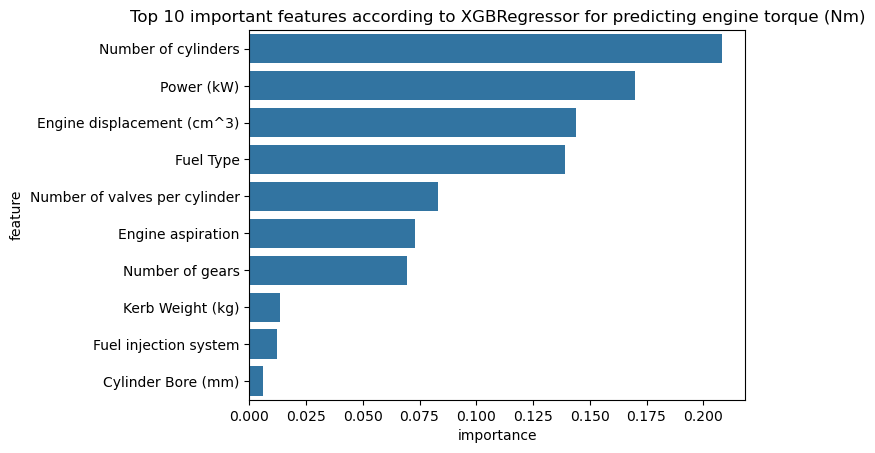

In [75]:
# Get feature importances
importances = best_model.feature_importances_

# Combine with column names
feat_imp = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
})

# Sort descending
feat_imp = feat_imp.sort_values(by='importance', ascending=False)
sns.barplot(data=feat_imp.iloc[:10], y='feature', x='importance')
plt.title("Top 10 important features according to XGBRegressor for predicting engine torque (Nm)")
plt.savefig("top10_important_features_torque_xgbregressor.svg", format="svg", bbox_inches='tight')
plt.show()

In [76]:
best_model.save_model("xgb_engine_torque_model.json")

In [77]:
data = df.copy()

target_feature = 'Engine displacement (cm^3)'

data['Start of production'] = data['Start of production'].dt.year
data['End of production'] = data['End of production'].dt.year

for col in data.select_dtypes(include=['object', 'category']).columns:
    data[col] = data[col].astype('category').cat.codes

data = data[data[target_feature].notna() & (data[target_feature] != 0)]

X = data.drop(target_feature, axis=1).fillna(0)
y = data[target_feature]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [78]:
param_grid = {
    'n_estimators': [500],
    'max_depth': [10],
    'subsample': [0.9],           # fraction of rows for each tree
    'colsample_bytree':[0.9],    # fraction of features for each tree
    'learning_rate': [0.05]
}

rmse_scorer = make_scorer(
    lambda y_true, y_pred: -np.sqrt(mean_squared_error(y_true, y_pred))
)

cv = KFold(n_splits=5, shuffle=True)

rf = xgb.XGBRegressor(n_jobs=-1)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=rmse_scorer,   # maximize negative RMSE
    cv=cv,
    n_jobs=5,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
print("Best CV score (RMSE):", -grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters: {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 500, 'subsample': 0.9}
Best CV score (RMSE): 67.80862287440709


In [79]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
regression_results.append(["XGBRegressor (Displacement)", rmse, r2])
print("RMSE:", rmse)
print("R2:", r2)

RMSE: 53.56377623917119
R2: 0.9982256889343262


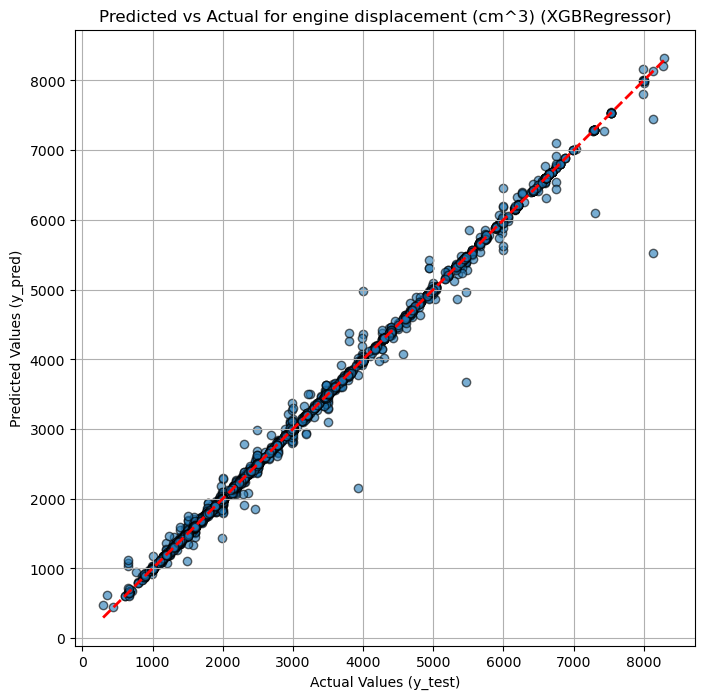

In [80]:
plt.figure(figsize=(8, 8))

plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
plt.xlabel("Actual Values (y_test)")
plt.ylabel("Predicted Values (y_pred)")
plt.title("Predicted vs Actual for engine displacement (cm^3) (XGBRegressor)")

# Add a diagonal line (perfect predictions)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'r--', linewidth=2)
plt.grid(True)
plt.savefig("pred_act_displacement_xgbregressor.svg", format="svg", bbox_inches='tight')
plt.show()

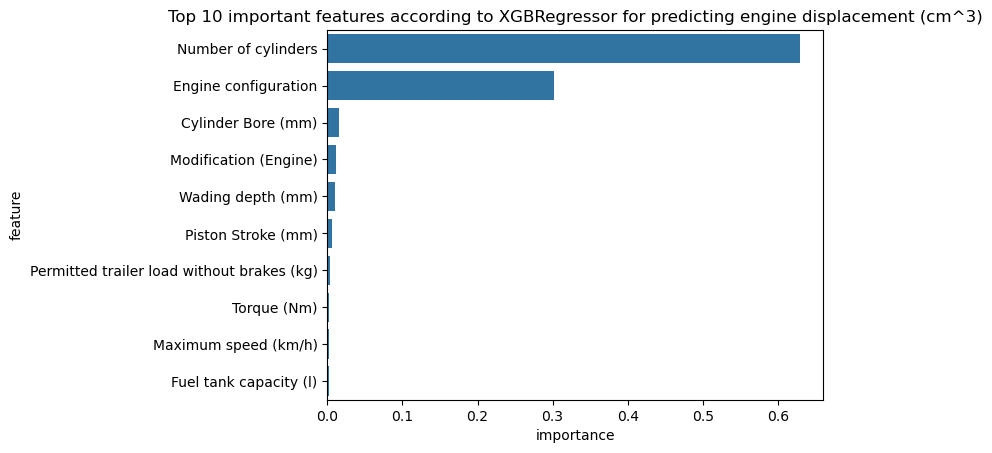

In [81]:
# Get feature importances
importances = best_model.feature_importances_

# Combine with column names
feat_imp = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
})

# Sort descending
feat_imp = feat_imp.sort_values(by='importance', ascending=False)
sns.barplot(data=feat_imp.iloc[:10], y='feature', x='importance')
plt.title("Top 10 important features according to XGBRegressor for predicting engine displacement (cm^3)")
plt.savefig("top10_important_features_displacement_xgbregressor.svg", format="svg", bbox_inches='tight')
plt.show()

In [82]:
best_model.save_model("xgb_engine_displacement_model.json")

In [83]:
from sklearn.preprocessing import LabelEncoder
data = df.copy()

target_feature = 'Fuel injection system'

data['Start of production'] = data['Start of production'].dt.year
data['End of production'] = data['End of production'].dt.year

#for col in data.select_dtypes(include=['object', 'category']).columns:
#    data[col] = data[col].astype('category').cat.codes

#data = data[data[target_feature].notna() & (data[target_feature] > 0)]

X = data.drop(target_feature, axis=1)
y_target = data[target_feature]

le = LabelEncoder()
y = le.fit_transform(y_target)  # converts categories to 0..N-1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [84]:
param_grid = {
    'n_estimators': [500],
    'max_depth': [10],
    'subsample': [0.9],           # fraction of rows for each tree
    'colsample_bytree':[0.9],    # fraction of features for each tree
    'learning_rate': [0.05]
}

cv = KFold(n_splits=5, shuffle=True)

rf = xgb.XGBClassifier(n_jobs=-1, enable_categorical=True)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=5,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
print("Best CV score (F1):", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
1 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\WhoseTheNerd\AppData\Roaming\Python\Python313\site-packages\xgboost\core.py", line 774, in inner_f
    return func(**kwargs)
  File "C:\Users\WhoseTheNerd\AppData\Roaming\Python\Python313\site-packages\xgboost\sklearn.py", line 1758, in fit
    r

Best hyperparameters: {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 500, 'subsample': 0.9}
Best CV score (F1): nan


In [85]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_pred, average='macro')
classification_results.append(["XGBClassifier (Fuel Injection)", f1])
print("F1:", f1)

F1: 0.9058560632177961


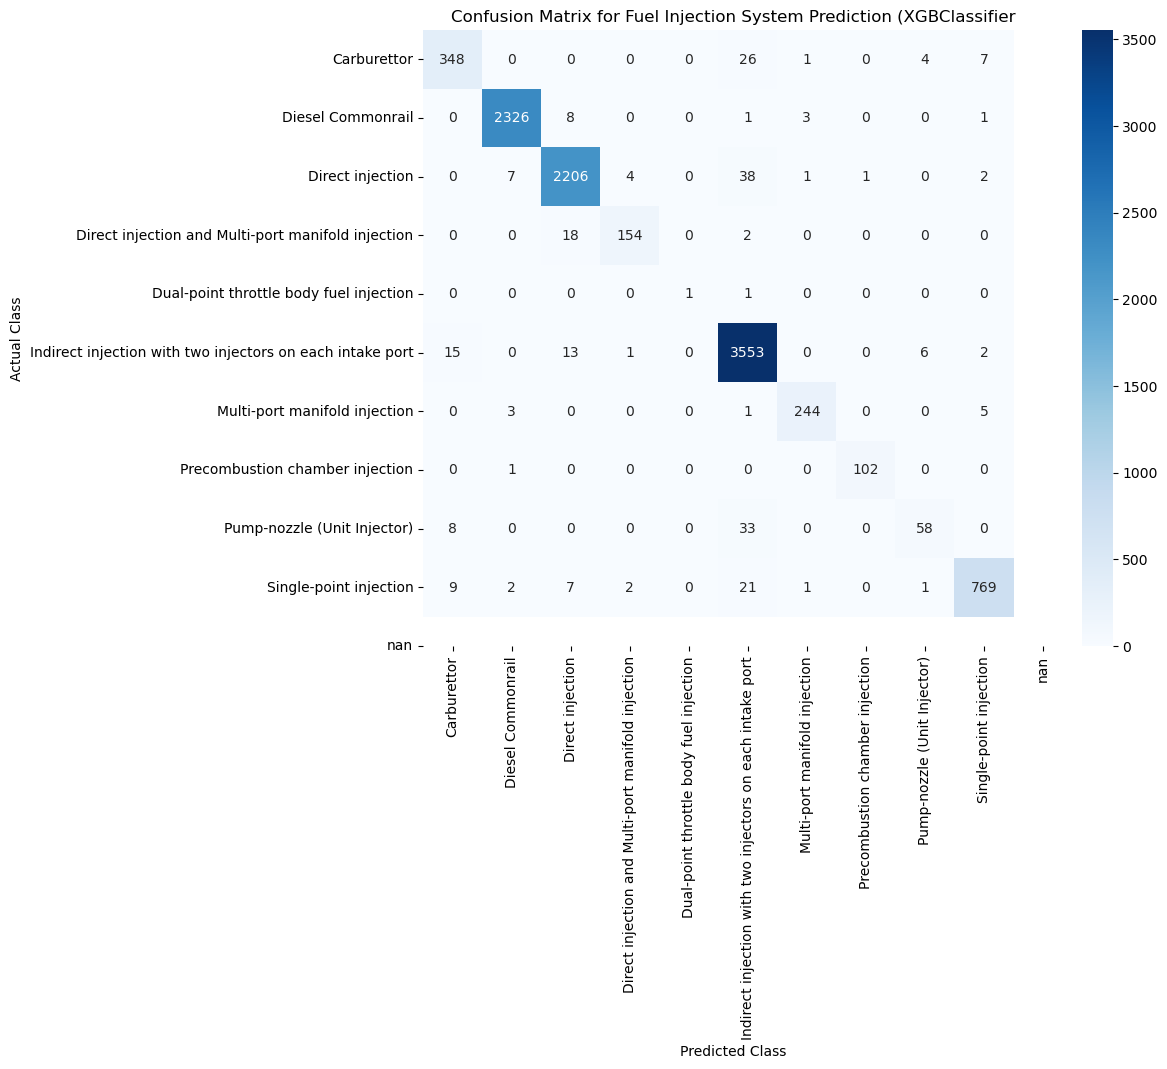

In [86]:
from sklearn.metrics import confusion_matrix
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)

plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("Confusion Matrix for Fuel Injection System Prediction (XGBClassifier")
plt.savefig("confusion_matrix_fuel_injection_xgbclassifier.svg", format="svg", bbox_inches='tight')
plt.show()

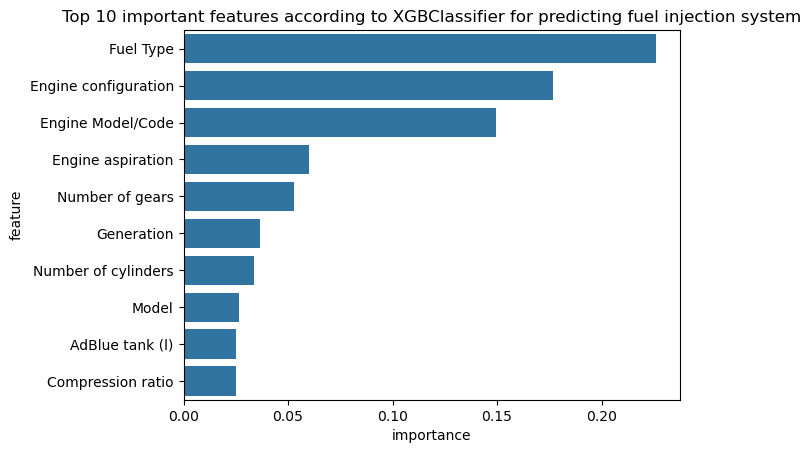

In [87]:
# Get feature importances
importances = best_model.feature_importances_

# Combine with column names
feat_imp = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
})

# Sort descending
feat_imp = feat_imp.sort_values(by='importance', ascending=False)
sns.barplot(data=feat_imp.iloc[:10], y='feature', x='importance')
plt.title("Top 10 important features according to XGBClassifier for predicting fuel injection system")
plt.savefig("top10_important_features_fuel_injection_xgbclassifier.svg", format="svg", bbox_inches='tight')
plt.show()

In [88]:
best_model.save_model("xgb_fuel_injection_system_model.json")

In [89]:
from sklearn.preprocessing import LabelEncoder
data = df.copy()

target_feature = 'Engine aspiration'

data['Start of production'] = data['Start of production'].dt.year
data['End of production'] = data['End of production'].dt.year

#for col in data.select_dtypes(include=['object', 'category']).columns:
#    data[col] = data[col].astype('category').cat.codes

#data = data[data[target_feature].notna() & (data[target_feature] > 0)]

X = data.drop(target_feature, axis=1)
y_target = data[target_feature]

le = LabelEncoder()
y = le.fit_transform(y_target)  # converts categories to 0..N-1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [90]:
param_grid = {
    'n_estimators': [500],
    'max_depth': [10],
    'subsample': [0.9],           # fraction of rows for each tree
    'colsample_bytree':[0.9],    # fraction of features for each tree
    'learning_rate': [0.05]
}

cv = KFold(n_splits=5, shuffle=True)

rf = xgb.XGBClassifier(n_jobs=-1, enable_categorical=True)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=5,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
print("Best CV score (F1):", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters: {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 500, 'subsample': 0.9}
Best CV score (F1): 0.7941165783341362


In [91]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_pred, average='macro')
classification_results.append(["XGBClassifier (Engine Aspiration)", f1])
print("F1:", f1)

F1: 0.8788713812221881


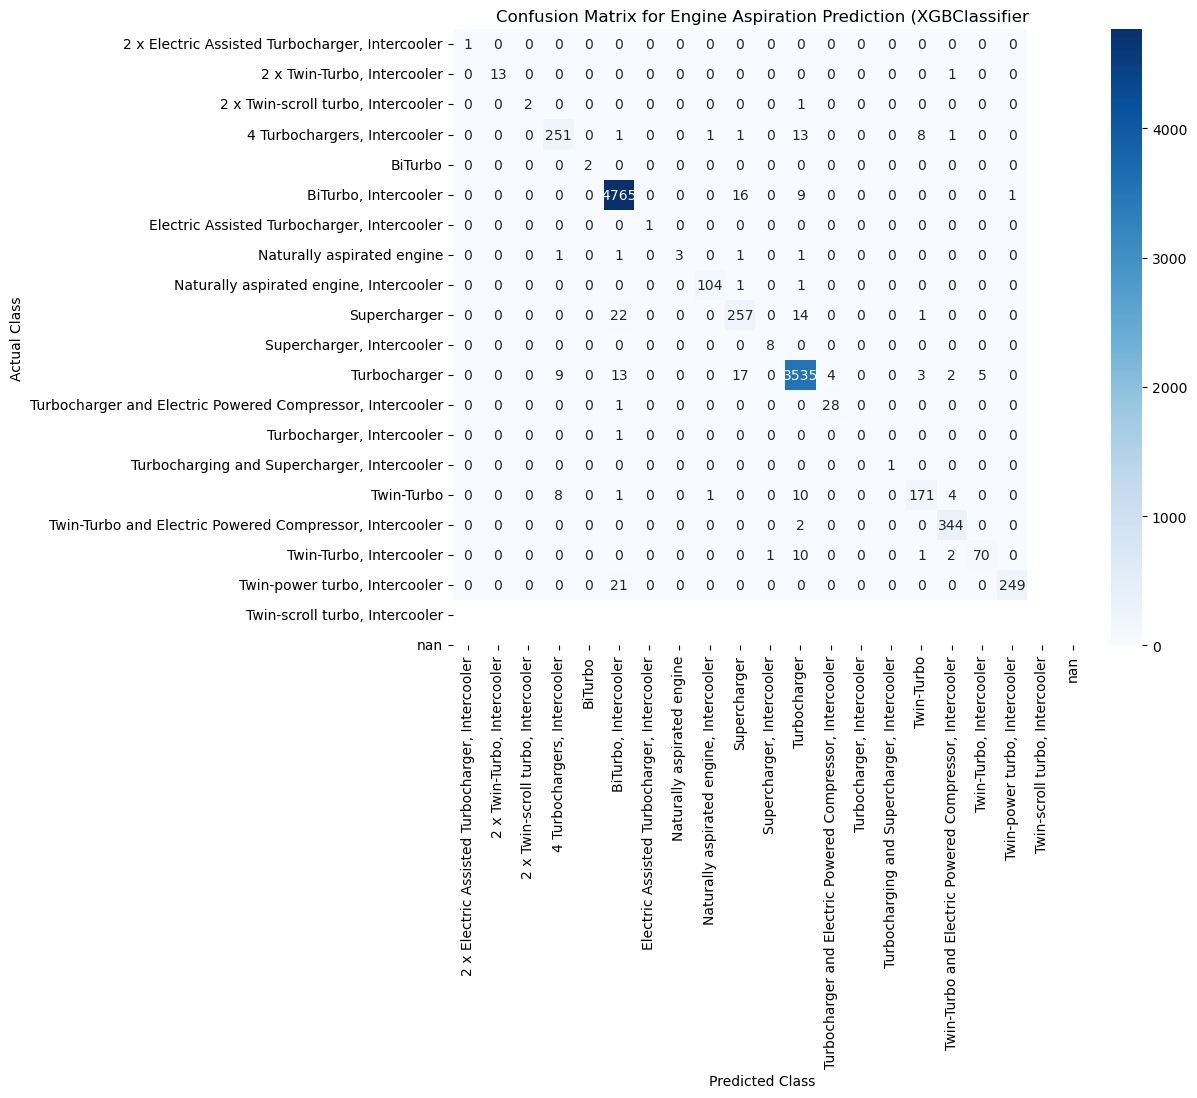

In [92]:
from sklearn.metrics import confusion_matrix
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)

plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("Confusion Matrix for Engine Aspiration Prediction (XGBClassifier")
plt.savefig("confusion_matrix_engine_aspiration_xgbclassifier.svg", format="svg", bbox_inches='tight')
plt.show()

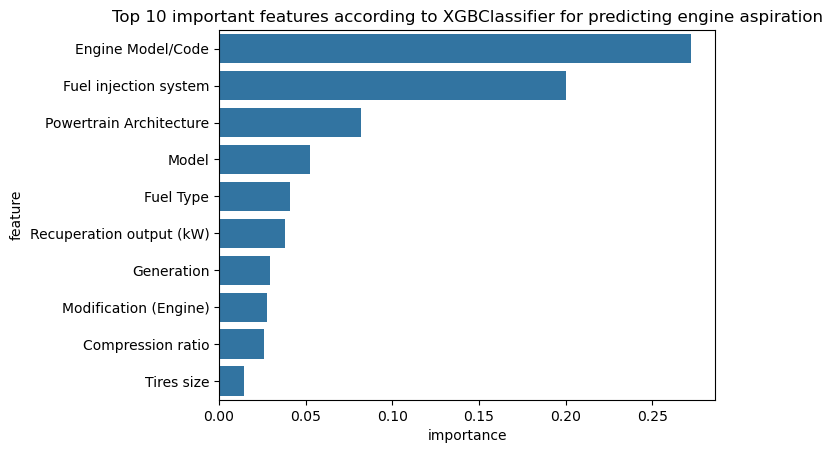

In [93]:
# Get feature importances
importances = best_model.feature_importances_

# Combine with column names
feat_imp = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
})

# Sort descending
feat_imp = feat_imp.sort_values(by='importance', ascending=False)
sns.barplot(data=feat_imp.iloc[:10], y='feature', x='importance')
plt.title("Top 10 important features according to XGBClassifier for predicting engine aspiration")
plt.savefig("top10_important_features_engine_aspiration_xgbclassifier.svg", format="svg", bbox_inches='tight')
plt.show()

In [94]:
best_model.save_model("xgb_engine_aspiration_model.json")

In [95]:
regression_df = pd.DataFrame(regression_results, columns=regression_columns)
classification_df = pd.DataFrame(classification_results, columns=classification_columns)

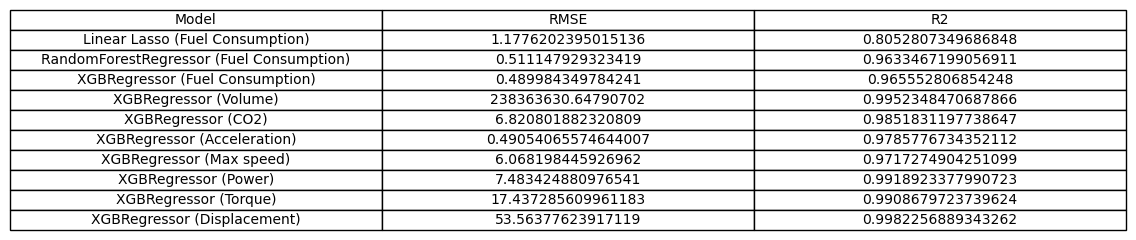

In [96]:
fig, ax = plt.subplots(figsize=(12, 2))

# Hide axes
ax.axis('off')

# Create table
table = ax.table(
    cellText=regression_df.values,
    colLabels=regression_df.columns,
    loc='center',
    cellLoc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)  # scale width, height
plt.savefig("model_performance.svg", format="svg", bbox_inches='tight')
plt.show()